<a href="https://colab.research.google.com/github/AtifQureshi110/Projects/blob/main/IMDb_Movie_Reviews_classification_by_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
# from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# dataset

In [3]:
# Importing IMDb Movie Reviews dataset
movie_reviews = pd.read_csv("/content/drive/MyDrive/BERT/Transformers/Selceted for interview/RNN/IMDB Dataset.csv.zip")
# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
movie_reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [5]:
# Checking for missing values
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

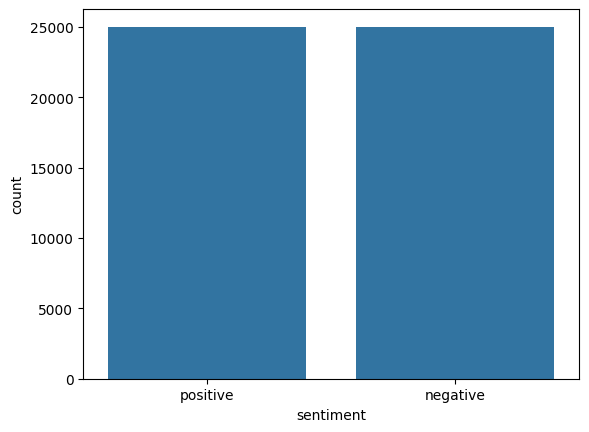

In [6]:
# Let's observe distribution of positive / negative sentiments in dataset
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

# preprocessing

In [7]:
movie_reviews["review"][2]

# You can see that our text contains punctuations, brackets, HTML tags and numbers
# We will preprocess this text in the next section

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
movie_reviews.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [11]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
# Sample cleaned up movie review

X[2]

# As we shall use Word Embeddings, stemming/lemmatization is not performed as a preprocessing step here

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

# train test split

In [13]:
# Converting sentiment labels to 0 & 1
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

# Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [15]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric for
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)
X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
# word_tokenizer.word_index contains all unique words
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [17]:
# Padding all reviews to fixed length 100
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
from numpy import asarray
embeddings_dictionary = dict()
# Unzip the file first
# we are using glove embadding to create the feature metric
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/BERT/Transformers/Selceted for interview/RNN/glove.6B.100d.txt.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/BERT/Transformers/Selceted for interview/RNN/')

In [19]:
# Read the unzipped file
# GloVe is an unsupervised learning algorithm to learn vector representation i.e word embedding for various words.
# GloVe stands for Global Vectors for Word Representations
glove_file_path = '/content/drive/MyDrive/BERT/Transformers/Selceted for interview/RNN/glove.6B.100d.txt'
with open(glove_file_path, encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
"""records[0] extracts the word.
asarray(records[1:], dtype='float32') converts the list of vector dimensions to a NumPy array of float32 data type.
The word and its vector dimensions are then added to the embeddings_dictionary."""

"records[0] extracts the word.\nasarray(records[1:], dtype='float32') converts the list of vector dimensions to a NumPy array of float32 data type.\nThe word and its vector dimensions are then added to the embeddings_dictionary."

In [20]:
# creating an embedding matrix using the GloVe word embeddings for all words in the corpus. Let's break down what each part of the code is doing
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = np.zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    # The code iterates through each word and its corresponding index in the word_index generated by word_tokenizer.
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        # If the embedding vector for the word exists (i.e., the word is present in the GloVe embeddings),
        #the corresponding row in the embedding_matrix is updated with this vector.
        embedding_matrix[index] = embedding_vector

In [21]:
embedding_matrix.shape

(92394, 100)

# Recurrent Neural Network (LSTM)

In [22]:
from keras.layers import LSTM

In [23]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))
""" Embedding() creates an embedding layer.
vocab_length is the size of the vocabulary (number of unique words).
100 is the dimensionality of the GloVe embeddings.
weights=[embedding_matrix] initializes the embedding layer with the pre-trained GloVe embeddings stored in embedding_matrix.
input_length=maxlen specifies the length of input sequences.
trainable=False ensures that the weights of the embedding layer (i.e., the GloVe embeddings) are not updated during training."""

' Embedding() creates an embedding layer.\nvocab_length is the size of the vocabulary (number of unique words).\n100 is the dimensionality of the GloVe embeddings.\nweights=[embedding_matrix] initializes the embedding layer with the pre-trained GloVe embeddings stored in embedding_matrix.\ninput_length=maxlen specifies the length of input sequences.\ntrainable=False ensures that the weights of the embedding layer (i.e., the GloVe embeddings) are not updated during training.'

In [24]:
# Model compiling
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [25]:
# Model Training
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 79s 308ms/step - loss: 0.5212 - acc: 0.7383 - val_loss: 0.4463 - val_acc: 0.8109
Epoch 2/6
250/250 [==============================] - 75s 299ms/step - loss: 0.4173 - acc: 0.8156 - val_loss: 0.3990 - val_acc: 0.8164
Epoch 3/6
250/250 [==============================] - 75s 299ms/step - loss: 0.3712 - acc: 0.8382 - val_loss: 0.3602 - val_acc: 0.8464
Epoch 4/6
250/250 [==============================] - 75s 301ms/step - loss: 0.3480 - acc: 0.8533 - val_loss: 0.3523 - val_acc: 0.8508
Epoch 5/6
250/250 [==============================] - 79s 317ms/step - loss: 0.3275 - acc: 0.8630 - val_loss: 0.3366 - val_acc: 0.8581
Epoch 6/6
250/250 [==============================] - 78s 311ms/step - loss: 0.3075 - acc: 0.8716 - val_loss: 0.3246 - val_acc: 0.8602


In [26]:
# Predictions on the Test Set
score = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 16s 53ms/step - loss: 0.3226 - acc: 0.8591


In [27]:
# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3225972354412079
Test Accuracy: 0.8590999841690063


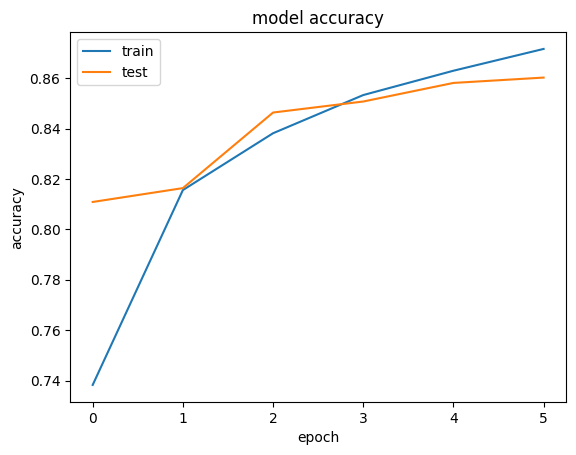

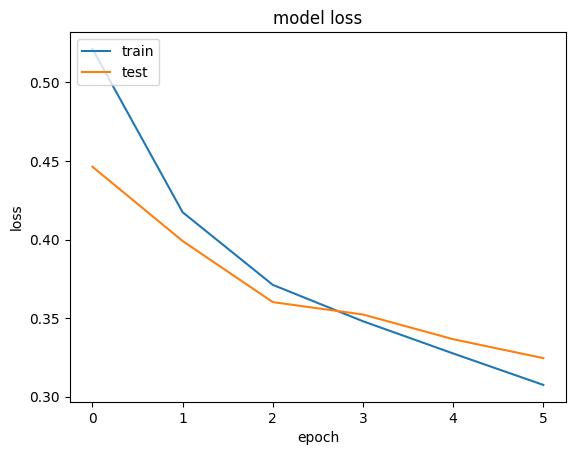

In [28]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [29]:
# Saving the model as a h5 file for possible use later

lstm_model.save(f"./c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Making Predictions on Live IMDb data

In [30]:
!ls # lists files in working directory

c1_lstm_model_acc_0.859.h5  drive  sample_data


In [32]:
# Load sample IMDb reviews csv, having ~6 movie reviews, along with their IMDb rating

import pandas as pd

# Read the CSV file
sample_reviews = pd.read_csv("/content/drive/MyDrive/BERT/Transformers/Selceted for interview/RNN/c2_IMDb_Unseen_Predictions.csv")

# Drop the 'Predicted Sentiments' and 'Unnamed: 0' columns
sample_reviews = sample_reviews.drop(['Predicted Sentiments', 'Unnamed: 0'], axis=1)

# Display the first 6 rows of the updated DataFrame
sample_reviews.head(6)


,Movie,Review Text,IMDb Rating
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3


In [33]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews['Review Text']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [34]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [35]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 0s 485ms/step


array([[0.7473078 ],
       [0.99114513],
       [0.18564996],
       [0.17532147],
       [0.97517663],
       [0.00862885]], dtype=float32)

In [36]:
# Writing model output file back to Google Drive

sample_reviews['Predicted Sentiments'] = np.round(unseen_sentiments*10,1)

df_prediction_sentiments = pd.DataFrame(sample_reviews['Predicted Sentiments'], columns = ['Predicted Sentiments'])
df_movie                 = pd.DataFrame(sample_reviews['Movie'], columns = ['Movie'])
df_review_text           = pd.DataFrame(sample_reviews['Review Text'], columns = ['Review Text'])
df_imdb_rating           = pd.DataFrame(sample_reviews['IMDb Rating'], columns = ['IMDb Rating'])


dfx=pd.concat([df_movie, df_review_text, df_imdb_rating, df_prediction_sentiments], axis=1)

dfx.to_csv("./c2_IMDb_Unseen_Predictions.csv", sep=',', encoding='UTF-8')

dfx.head(6)

,Movie,Review Text,IMDb Rating,Predicted Sentiments
0,Ex Machina,Intelligent Movie.\nThis movie is obviously al...,9,7.5
1,Ex Machina,Extraordinary and thought-provoking.\n'Ex mach...,10,9.9
2,Ex Machina,"Poor story, only reasonable otherwise.\nIf I h...",3,1.9
3,Ex Machina,Had Great Potential.\nThis movie is one of the...,1,1.8
4,Eternals,Amazing visuals and philosophical concepts!\n\...,10,9.8
5,Eternals,Worst MCU film ever\n\nFollowing the events of...,3,0.1


# summary

1. **Import Libraries**: Imported necessary libraries for data processing and model building.
2. **Read Dataset**: Loaded the IMDB dataset.
3. **Data Visualization**: Performed some visualizations to understand the dataset better.
4. **Data Cleaning**: Removed unnecessary information from the data using the `re` and `nltk` libraries.
5. **Target Conversion**: Converted the target column information into numerical format.
6. **Data Splitting**: Split the dataset into training and testing sets using the `sklearn` library.
7. **Text Tokenization**: Created a `Tokenizer` object and used it to build a word index dictionary with the `fit_on_texts()` method. Converted sentences to numerical format using the `texts_to_sequences()` method.
8. **Padding Sequences**: Added padding to the `X_train` and `X_test` data using the `pad_sequences` method.
9. **GloVe Embeddings**: Used GloVe embeddings to create the feature matrix. Retained GloVe embeddings for words in the dataset and discarded the rest.
10. **Model Building**: Built the model using a Sequential model with Embedding, LSTM, and Dense layers. Compiled the model with the 'adam' optimizer, 'binary_crossentropy' loss, and 'accuracy' metric.
11. **Model Training**: Trained the model using the `fit` method.
12. **Model Evaluation**: Evaluated the model using the `evaluate` method and achieved a test accuracy of 84%.
13. **Model Saving and Testing**: Saved the model and tested it on a completely new dataset, yielding satisfactory results.
Today, i did a mini project related to NLP with LSTM algorithm. Firstly i imported the necessary libraries and loading the IMDB dataset. After performing some initial visualizations to understand the data better, I cleaned the dataset by removing unnecessary information using the `re` and `nltk` libraries. I converted the target column into numerical format and split the dataset into training and testing sets with the `sklearn` library. To process the text data, I created a `Tokenizer` object and built a word index dictionary using the `fit_on_texts()` method, then transformed the sentences into numerical sequences with the `texts_to_sequences()` method. I added padding to the `X_train` and `X_test` data using the `pad_sequences` method. To enhance the model's performance, I incorporated GloVe embeddings, retaining those that corresponded to words in my dataset. I then constructed a Sequential model with Embedding, LSTM, and Dense layers, and compiled it using the 'adam' optimizer, 'binary_crossentropy' loss, and 'accuracy' metric. After training the model with the `fit` method, I evaluated its performance using the `evaluate` method and achieved a test accuracy of 84%. Finally, I saved the model and tested it on a completely new dataset, which produced satisfactory results.